## Introduction

In the telecommunications sector, identifying effective and ineffective operators is essential to ensuring service quality and user satisfaction. Analyzing operational metrics, such as the total number of calls made and their duration, allows for evaluating provider performance and detecting potential service gaps. This project applied statistical tests to test hypotheses related to operator efficiency, using nonparametric tools to address the lack of normality in the data. The results obtained provide an objective basis for decision-making aimed at improving service and optimizing resources in the sector.

## Exploratory Data Analysis

### Data preparation

In [1]:
import pandas as pd

In [2]:
clients = pd.read_csv("telecom_clients_us.csv")
df = pd.read_csv("telecom_dataset_us.csv")

In [3]:
print(df.info(),"\n")
print(clients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    obj

In [4]:
df.sample(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
28386,167180,2019-10-24 00:00:00+03:00,out,True,905932.0,True,2,0,2
43943,168021,2019-10-25 00:00:00+03:00,out,False,939222.0,True,7,0,177
751,166405,2019-08-18 00:00:00+03:00,out,False,882686.0,True,5,0,10
16564,166916,2019-10-22 00:00:00+03:00,in,False,906406.0,False,12,1236,1493
49373,168187,2019-11-25 00:00:00+03:00,in,False,937762.0,False,2,175,193
18392,166974,2019-10-18 00:00:00+03:00,in,False,900352.0,False,9,821,974
4753,166511,2019-10-10 00:00:00+03:00,out,False,891410.0,False,44,4582,5043
27197,167175,2019-09-24 00:00:00+03:00,out,False,905844.0,True,4,0,78
27280,167175,2019-10-12 00:00:00+03:00,out,False,905842.0,False,5,905,970
18594,166975,2019-09-05 00:00:00+03:00,in,True,NaN,True,4,0,62


In [5]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


### Data conversion

In [ ]:
#Convert columns of the data frame df
df ["date"] = pd.to_datetime(df ["date"], errors= "coerce").dt.date #Since it is observed that the schedule was incorrect, only the date was left.
df ["operator_id"] = df ["operator_id"].astype("object")

In [ ]:
#Convert client values
clients ["user_id"] = clients ["user_id"].astype("object")
clients ["date_start"] = pd.to_datetime(clients ["date_start"], errors= "coerce")

### Handling missing values

In [8]:
df_merged = df.merge(clients, on="user_id", how="left")


In [ ]:
#Null operator data is eliminated since it is the one that will be evaluated
df_operadores = df_merged.dropna(subset=["operator_id"]).copy()
df_operadores["operator_id"] = df_operadores["operator_id"].astype(int)

### Handling duplicate values

In [ ]:
print(df_operadores.duplicated().sum()) #We will not delete them because we do not have a record of the time of day the call was made.

4184


### Nuevas variables 

In [ ]:
#This data frame is created to group and evaluate the figures of our operators.
df_operadores = df_merged.groupby(["operator_id", "tariff_plan", "date"]).agg({
    "calls_count": "sum",
    "call_duration": "mean",
    "total_call_duration": "mean",
    "is_missed_call": "sum"
}).reset_index()


In [ ]:
#Average per call
df_operadores["avg_call_duration"] = df_operadores["call_duration"] / df_operadores["calls_count"]
df_operadores["avg_total_call_duration"] = df_operadores["total_call_duration"] / df_operadores["calls_count"]

In [ ]:
#Missed calls
df_operadores["missed_call_rate"] = df_operadores["is_missed_call"] / df_operadores["calls_count"]


In [ ]:
# Average percentage of missed calls per operator
print(df_operadores.groupby('operator_id')['missed_call_rate'].mean().sort_values(ascending=False))

operator_id
924572.0    1.0
914626.0    1.0
954284.0    1.0
928282.0    1.0
914272.0    1.0
           ... 
891906.0    0.0
895140.0    0.0
895170.0    0.0
969268.0    0.0
884524.0    0.0
Name: missed_call_rate, Length: 1092, dtype: float64


In [15]:
num_operadores = df_operadores['operator_id'].nunique()
print(num_operadores)

1092


There are 1,092 people working, of whom, on average, only one call has been missed. Overall, most operators are "efficient." We'll take other metrics into account.

In [16]:
df_operadores["ineficaz"] = df_operadores["missed_call_rate"] > 0.10 


To measure operator inefficiency, we created the variable "inefficiency" by filtering out those operators who lose at least 10% of their calls.

In [ ]:
# How many inefficient operators are there?
num_ineficaces = df_operadores[df_operadores["ineficaz"]].operator_id.nunique()
print(f"Inefficient operators: {num_ineficaces}")


Operadores ineficaces: 739


In [ ]:
# Ineffective operators (at least 1 day)
ineficaces_unicos = df_operadores.loc[df_operadores["ineficaz"], "operator_id"].nunique()

# Total operators
operadores_totales = df_operadores["operator_id"].nunique()

# Percentage
porcentaje = (ineficaces_unicos / operadores_totales) * 100

print(f"Inefficient single operators: {ineficaces_unicos}")
print(f"Total operators: {operadores_totales}")
print(f"Percentage: {porcentaje:.2f}%")

Operadores ineficaces únicos: 739
Operadores totales: 1092
Porcentaje: 67.67%


67.67% of operators lose 10% of their calls.

In [19]:
resumen = df_operadores.groupby("operator_id").agg(
    total_llamadas=("calls_count", "sum"),
    total_perdidas=("is_missed_call", "sum")
)

resumen["missed_call_rate"] = resumen["total_perdidas"] / resumen["total_llamadas"]

# Clasificar como ineficaz en promedio
resumen["ineficaz"] = (resumen["missed_call_rate"] > 0.10) | (resumen["total_perdidas"] > 10)

print(resumen.sort_values("total_perdidas", ascending=False).head(10))

             total_llamadas  total_perdidas  missed_call_rate  ineficaz
operator_id                                                            
885876.0              66049             135          0.002044      True
891410.0               3773             131          0.034720      True
893804.0               6570             130          0.019787      True
901880.0               4655             128          0.027497      True
891414.0               3374             126          0.037344      True
901884.0               2846             115          0.040408      True
885890.0              66016             110          0.001666      True
887276.0               1421             101          0.071077      True
879898.0               7974             100          0.012541      True
905538.0               3843              99          0.025761      True


We can see that the operator with the most missed calls also receives the most calls. However, there is another group of operators that still loses a large volume of calls while receiving fewer incoming calls.

In [ ]:
def clasificar(row):
    # Very ineffective: very high loss rate or large absolute losses on low volume
    if row["missed_call_rate"] > 0.10 or (row["total_perdidas"] > 50 and row["total_llamadas"] < 2000):
        return "Muy ineficaz"
    
    # Risk: Moderate loss rate or significant absolute losses
    elif row["missed_call_rate"] > 0.05 or row["total_perdidas"] > 20:
        return "Riesgo"
    
    # If you do not fall into the above cases, it is effective
    else:
        return "Eficaz"

resumen["categoria"] = resumen.apply(clasificar, axis=1)

In [21]:
resumen.head()

,total_llamadas,total_perdidas,missed_call_rate,ineficaz,categoria
operator_id,,,,,
879896.0,1131,50,0.044209,True,Riesgo
879898.0,7974,100,0.012541,True,Riesgo
880020.0,54,7,0.129630,True,Muy ineficaz
880022.0,219,33,0.150685,True,Muy ineficaz
880026.0,2439,94,0.038540,True,Riesgo


In [22]:
print((resumen ["categoria"] == "Muy ineficaz").value_counts())

categoria
False    741
True     351
Name: count, dtype: int64


In [32]:
print((resumen ["categoria"] == "Muy ineficaz").sort_values(ascending=False))

operator_id
909892.0     True
914870.0     True
914816.0     True
914636.0     True
914630.0     True
            ...  
919464.0    False
919476.0    False
919482.0    False
919490.0    False
973286.0    False
Name: categoria, Length: 1092, dtype: bool


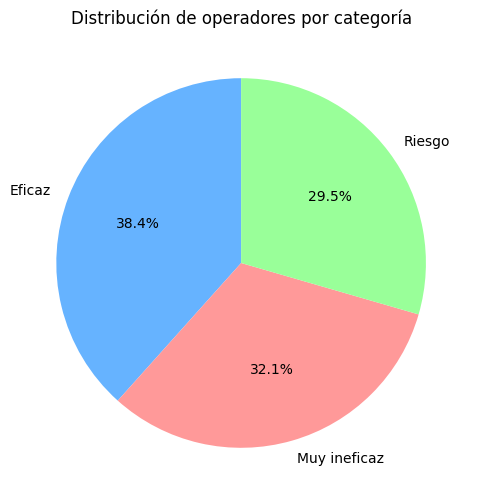

In [ ]:
import matplotlib.pyplot as plt

# Count operators by category
conteo_categorias = resumen["categoria"].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    conteo_categorias,
    labels=conteo_categorias.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff","#ff9999","#99ff99"]  # Colors for each category
)
plt.title("Distribution of operators by category")
plt.show()

A total of 351 highly ineffective operators were identified, considering the percentage of incoming calls and the total number of missed calls. This group represents 32.1% of the total number of operators.
Additionally, there is a second group that, while not completely ineffective, is at risk of becoming so. This segment would benefit from training and follow-up programs to improve their productivity and prevent further deterioration in their performance.

# Hypothesis

#### Normality of the sample

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(resumen["total_perdidas"])  
print("Statistic=%.3f, p=%.3f" % (stat, p))

if p > 0.05:
    print("Normal data")
else:
    print("Non-normal data")

Statistic=0.707, p=0.000
Datos no normales


In [ ]:
stat, p = shapiro(resumen["total_llamadas"])  
print("Statistic=%.3f, p=%.3f" % (stat, p))

if p > 0.05:
    print("Normal data")
else:
    print("Non-Normal dara")

Statistic=0.163, p=0.000
Datos no normales


### Hypothesis 1

Operators with a higher number of missed incoming calls have a significantly higher ineffectiveness rate than those with fewer missed calls.

H₀ (null): There is no significant difference in the ineffectiveness rate between operators with many missed calls and those with few.

H₁ (alternative): Operators with many missed calls have a significantly higher ineffectiveness rate.

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu

# We created the column to divide into groups according to the median number of missed calls
mediana_perdidas = resumen["total_perdidas"].median()
resumen["grupo_perdidas"] = resumen["total_perdidas"].apply(lambda x: "Alta" if x > mediana_perdidas else "Baja")

# We separate the groups
alta = resumen[resumen["grupo_perdidas"] == "Alta"]["missed_call_rate"]
baja = resumen[resumen["grupo_perdidas"] == "Baja"]["missed_call_rate"]

# Quick normality test to decide the test (optional)
print("Media Alta:", alta.mean(), "Media Baja:", baja.mean())

# Nonparametric test Mann-Whitney U (recommended if normality is unknown)
stat, p = mannwhitneyu(alta, baja, alternative='two-sided')
print("Estadístico U:", stat)
print("p-valor:", p)

# Interpretation
if p < 0.05:
    print("We reject H0: there is a significant difference in the failure rate between the groups.")
else:
    print("We do not reject H0: there is no significant difference between the groups.")

Media Alta: 0.06489146619883225 Media Baja: 0.133457512608467
Estadístico U: 159886.5
p-valor: 0.032441198223380506
Rechazamos H0: hay diferencia significativa en la tasa de ineficacia entre los grupos.


C:\Users\alast\AppData\Local\Temp\ipykernel_22204\3230084237.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="grupo_perdidas", y="missed_call_rate", data=resumen, palette="Set2")


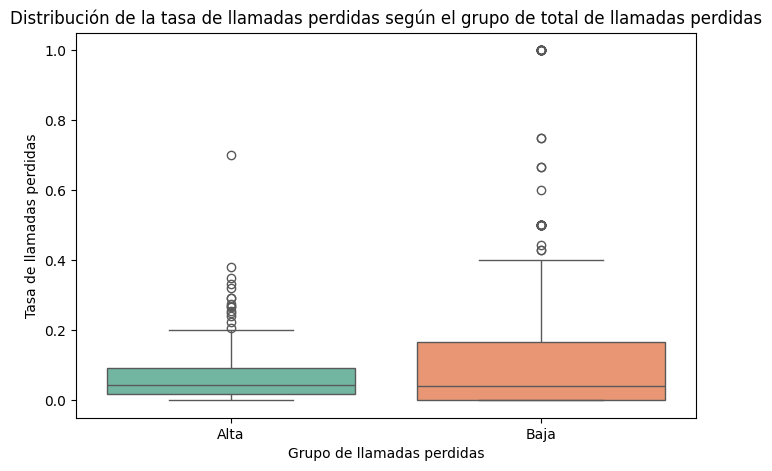

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.boxplot(x="grupo_perdidas", y="missed_call_rate", data=resumen, palette="Set2")
plt.title("Distribution of missed call rate by total missed call group")
plt.xlabel("Missed call group")
plt.ylabel("Missed call rate")
plt.show()

A total of 351 highly ineffective operators were identified in terms of the percentage of incoming calls and lost calls, representing 32.1% of the total. This finding allows us to reject H0 and accept H1, confirming the existence of a significant group of low-performing operators. Furthermore, another group of operators at risk of ineffectiveness was identified, who could improve with targeted training.

### Hypothesis 2

H0: There is no significant difference in the missed call rate between operators with high and low incoming call volumes.

H1: There is a significant difference.

In [ ]:
from scipy.stats import mannwhitneyu

# We divide operators based on the median number of incoming calls
mediana_llamadas = resumen["total_llamadas"].median()
resumen["grupo_llamadas"] = resumen["total_llamadas"].apply(lambda x: "Alta" if x > mediana_llamadas else "Baja")

# We separate the groups
alta_llamadas = resumen[resumen["grupo_llamadas"] == "Alta"]["missed_call_rate"]
baja_llamadas = resumen[resumen["grupo_llamadas"] == "Baja"]["missed_call_rate"]

# Comparison means
print("Media Alta Llamadas:", alta_llamadas.mean(), "Media Baja Llamadas:", baja_llamadas.mean())

# Mann-Whitney U statistical test
stat, p = mannwhitneyu(alta_llamadas, baja_llamadas, alternative='two-sided')
print("Estadístico U:", stat)
print("p-valor:", p)

# Interpretation
if p < 0.05:
    print("We reject H0: there is a significant difference in the ineffectiveness rate based on call volume.")
else:
    print("H0 is not rejected: there is no significant difference in the ineffectiveness rate between groups.")

Media Alta Llamadas: 0.04836503970131468 Media Baja Llamadas: 0.15287225241628052
Estadístico U: 131069.5
p-valor: 0.0005292654466442417
Rechazamos H0: hay diferencia significativa en la tasa de ineficacia según el volumen de llamadas.


C:\Users\alast\AppData\Local\Temp\ipykernel_22204\4233270115.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="grupo_llamadas", y="missed_call_rate", data=resumen, palette="Set3")


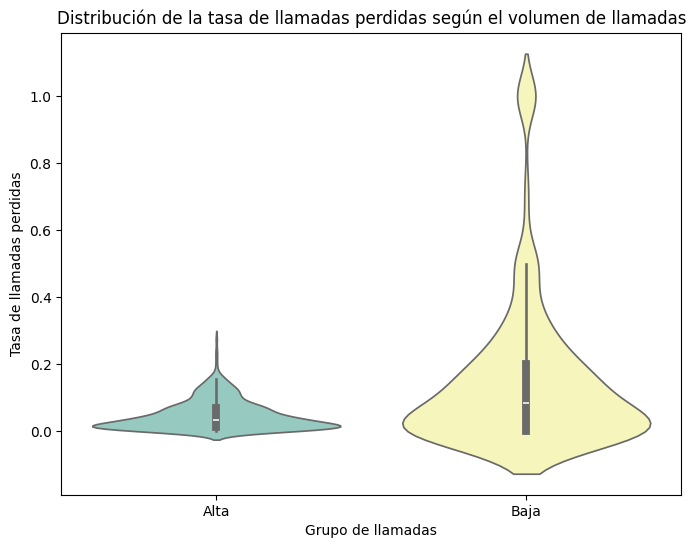

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(x="grupo_llamadas", y="missed_call_rate", data=resumen, palette="Set3")
plt.title("Distribution of missed call rate by call volume")
plt.xlabel("Call group")
plt.ylabel("Missed call rate")
plt.show()

C:\Users\alast\AppData\Local\Temp\ipykernel_22204\1773431982.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="grupo_llamadas", y="missed_call_rate", data=resumen, palette="Set2")


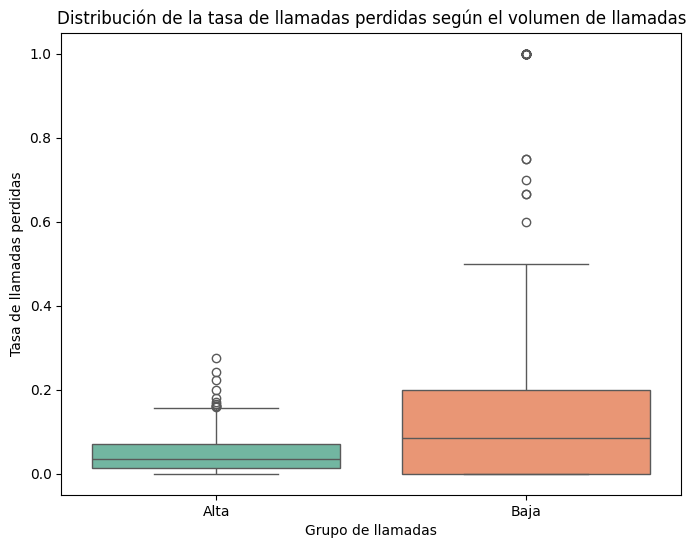

In [ ]:
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="grupo_llamadas", y="missed_call_rate", data=resumen, palette="Set2")
plt.title("Distribution of missed call rate by call volume")
plt.xlabel("Call group")
plt.ylabel("Missed call rate")
plt.show()

Statistical analysis (Mann-Whitney U) compared the ineffectiveness rate between operators with high and low call volumes. The results showed that the difference was statistically significant (p < 0.05), indicating that call volume influences the probability of ineffectiveness. This leads to rejecting H0 and accepting H1: operators with more incoming calls exhibit different ineffectiveness behavior compared to those with lower call volumes.

## Conclusión

The analysis confirms that there is a significant group of highly ineffective operators (32.1% of the total), which represents a direct risk to service productivity. Furthermore, it was found that the volume of incoming calls significantly influences the ineffectiveness rate, demonstrating that not all operators face the same performance conditions. Together, these findings highlight the need to implement differentiated strategies: immediate corrective interventions for highly ineffective operators and preventive training programs for those at risk, in order to improve overall efficiency and reduce losses.